## Luminance-only LGN circuits -- GPU1

In [7]:
import sys
sys.path.insert(0, './')

import os
import h5py 

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

if myhost=='hoser':
    sys.path.insert(0, '/Users/dbutts/')
    dirname = os.path.join('.', 'checkpoints')
    datadir = '/Users/dbutts/V1/Conway/'
else:
    #sys.path.insert(0, '/home/dbutts/Code/') 
    datadir = '/home/dbutts/ColorV1/Data/'  
    dirname = '/home/dbutts/ColorV1/CLRworkspace/' # Working directory 

import numpy as np
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time
import dill

from NTdatasets.generic import GenericDataset
import NTdatasets.conway.cloud_datasets as datasets

# Utilities
import ColorDataUtils.ConwayUtils as CU
import ColorDataUtils.EyeTrackingUtils as ETutils
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

from ColorDataUtils import mattplotlib as mplt

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)
print(device)
%load_ext autoreload
%autoreload 2

Running on Computer: [ca1]
Save_dir = /home/dbutts/ColorV1/CLRworkspace/
cuda:1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Load data (all stim)
fn = 'Jocamo_220715_full_CC_ETCC_nofix_v08'
num_lags=16

t0 = time()
data = datasets.ColorClouds(
    datadir=datadir, filenames=[fn], eye_config=3, drift_interval=16, 
    luminance_only=True, binocular=False, include_MUs=True, num_lags=num_lags,
    trial_sample=True)
t1 = time()
print(t1-t0, 'sec elapsed')

NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_nofix_v08_DFextra.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat( datadir+'Jocamo_220715_full_CC_ETCC_v08_ETupdate.mat')
sac_ts_all = matdat['ALLsac_bins'][0, :]

data.process_fixations( sac_ts_all )
sac_tsB = matdat['sac_binsB'][0, :]
sac_tsL = matdat['sac_binsL'][0, :]
sac_tsR = matdat['sac_binsR'][0, :]

NFIX = torch.max(data.fix_n).detach().numpy() 
print(NFIX, 'fixations')
et1kHzB = matdat['et1kHzB']
et60B = matdat['et60HzB']
et60all = matdat['et60Hz_all']

Reducing stimulus channels (3) to first dimension
Loading data into memory...
Adjusting stimulus read from disk: mean | std = -0.000 | 0.269
T-range: 0 167520
  Trimming experiment 365280->167520 time points based on eye_config and Tmax
100.45890522003174 sec elapsed
167520 (167520 valid) time points
29 laminar units, 210 ET units
  Redoing fix_n with saccade inputs: 6827 saccades
3795 fixations


In [9]:
# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, UTunits], data.dfs[:, UTunits]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valET = UTunits[a]
NCv = len(valET)
print("%d out of %d units used"%(len(valET), len(UTunits)))

## CONVERT LLsNULL, which is based on 

# Read in previous data
dirname2 = dirname+'0715/et/'
matdat = sio.loadmat(dirname2+'LLsGLM.mat')
Dreg = matdat['Dreg']
top_corner = matdat['top_corner'][:, 0]

adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=6,  # changed from 4
    optimize_graph=False, weight_decay = 0.2)
adam_pars['device'] = device

data.set_cells(valET)

174 out of 195 units used
Output set to 174 cells


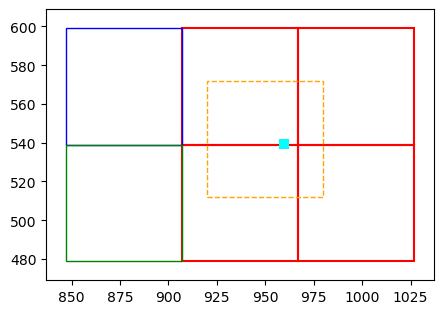

  Stim expansion for shift: [900, 492, 1000, 592]
  Writing lam stim 0: overlap 60, 47
  Writing lam stim 1: overlap 60, 53
  Writing lam stim 2: overlap 33, 53
  Writing lam stim 3: overlap 33, 47
  Writing ETstim 0: overlap 7, 53
  Writing ETstim 1: overlap 7, 47
  Adding fixation point
  Shifting stim...
  CROP: New stim size: 60 x 60
  Done


In [10]:
# Load shifts and previous models
dirname2 = dirname+'0715/et/'
SHfile = sio.loadmat( dirname2 + 'BDshifts1.mat' )
fix_n = SHfile['fix_n']
shifts = SHfile['shifts']
metricsLL = SHfile['metricsLL']
metricsTH = SHfile['metricsTH']
ETshifts = SHfile['ETshifts']
ETmetrics = SHfile['ETmetrics']
Ukeeps = SHfile['Ctrain']
XVkeeps = SHfile['Cval']

# Make 60x60 STAs (and GLMs)
Xshift = 14 #8+4 
Yshift = -3 #-10+4
NX = 60

new_tc = np.array([top_corner[0]-Xshift, top_corner[1]-Yshift], dtype=np.int64)
data.draw_stim_locations(top_corner = new_tc, L=NX)

data.assemble_stimulus(top_corner=[new_tc[0], new_tc[1]], L=NX, fixdot=0, shifts=-shifts)

In [11]:
goodfix = np.where(ETmetrics[:,1] < 0.80)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
#DFsave = deepcopy(data2.dfs)  # this is also in data.dfs
data.dfs_out *= valfix
print("%0.1f%% fixations remaining"%(100*len(goodfix)/ETmetrics.shape[0]))

lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-8,
    tolerance_grad=1e-8,
    history_size=100,
    batch_size=20,
    max_epochs=3,
    max_iter = 500,
    device = device)

adam_parsT = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=4, num_workers=0,
    learning_rate=0.01, early_stopping_patience=10,  # changed from 4
    optimize_graph=False, weight_decay = 0.2)
adam_parsT['device'] = device
adam_parsT['accumulated_grad_batches'] = 6

68.5% fixations remaining


In [12]:
dirname2 = dirname+'0715/NewGLMs/'
matdat = sio.loadmat(dirname2+'J0715ProcGLMinfo.mat')
LLsNULL = matdat['LLsNULL'][:,0]
LLsGLM = matdat['LLsGLM'][:,0]
LLsGLM2 = matdat['LLsGLM2'][:,0]
drift_terms = matdat['drift_terms']
valET = matdat['cells'] 
RFcenters = matdat['RFcenters']
#'Gregs': Gopt[:,None], 'XTregs': Xopt
#'top_corner': new_tc[:, None]})
mu0s = utils.pixel2grid(deepcopy(RFcenters[:, [1, 0]]), L=NX)

In [ ]:
def quick_readout_display(w, start_n, num_subs, inh_frac):
    NF, NC = w.shape
    num_layers = (NF-start_n)//num_subs
    assert num_layers == (NF-start_n)/num_subs, "something wrong %f"%(NF-start_n)/num_subs
    NE = num_subs-num_subs//inh_frac
    for ii in range(num_layers):
        w[start_n+num_subs*ii+np.arange(NE, num_subs), :] *= -1
    ss(rh=8)
    imagesc(w, cmap='bwr')
    for ii in range(num_layers):
        plt.plot(np.ones(2)*(start_n-0.5)+ii*num_subs, [-0.5, NC-0.5],'k')

## LGN LUMINANCE MODELING

In [ ]:
import pickle

LGNlags = 11
LGNsubs = 4
fw0 = 7

proj_width = 17

Treg = 0.01
Xreg = 0.000001
Mreg = 0.0001
Creg = None
Dreg = 0.5
Gnet = 0.005

num_iter = 4
num_subs = 30
fwI = 7


LGNpars = STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=LGNsubs, bias=False, norm_type=1,
    filter_dims=[1,fw0,fw0,LGNlags] , NLtype='relu', initialize_center=True)
LGNpars['output_norm']='batch'
LGNpars['window']='hamming'
LGNpars['reg_vals'] = {'d2x':Xreg, 'd2t':Treg, 'center': Creg, 'edge_t':100}  

proj_pars = ConvLayer.layer_dict( 
    num_filters=num_subs, bias=False, norm_type=1, num_inh=num_subs//2,
    filter_dims=proj_width, NLtype='lin', initialize_center=True)
proj_pars['output_norm']='batch'
proj_pars['window']='hamming'

Ilayers = IterSTlayer.layer_dict(    
    num_filters=num_subs, bias=False, num_iter=num_iter, output_config='full',
    pos_constraint=True,
    norm_type=1, num_inh=num_subs//2, filter_width=fwI, num_lags=2, 
    NLtype='relu', initialize_center=False) 
Ilayers['output_norm'] = 'batch'
# Ilayers['reg_vals'] = {'glocal': Gnet}  
        
scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n = 'stim', layer_list=[LGNpars, proj_pars, Ilayers], scaffold_levels=[1,2] )

## 1: READOUT
readout_pars = ReadoutLayer.layer_dict(
    num_filters=NCv, NLtype='lin', bias=False, pos_constraint=True)
readout_pars['gauss_type'] = 'isotropic'
readout_pars['reg_vals'] = {'max': Mreg} 

readout_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_pars], ffnet_type='readout')

## 2: DRIFT
drift_pars = NDNLayer.layer_dict( 
    input_dims=[1,1,1,NA], num_filters=NCv, bias=False, norm_type=0, NLtype='lin')
drift_pars['reg_vals'] = {'d2t': Dreg } 

drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars] )

## 3: COMB 
comb_layer = ChannelLayer.layer_dict(
    num_filters = NCv, NLtype='softplus', bias=True)
comb_layer['weights_initializer'] = 'ones'

comb_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[1,2],
    layer_list = [comb_layer], ffnet_type='add')


## LESS ITERATIONS AND LINEAR PROJECTION LAYER (!)

LGNmods = []
cnn_iter = NDN.NDN( ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')
cnn_iter.block_sample = True

## Network 1: readout: fixed mus / sigmas
cnn_iter.networks[1].layers[0].sample = False
#cnnI1.networks[1].layers[0].mu.data = deepcopy(cnn0x.networks[1].layers[0].mu.data)
cnn_iter.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
cnn_iter.networks[1].set_parameters(val=False, name='mu')
cnn_iter.networks[1].set_parameters(val=False, name='sigma')

## Network 2: drift: not fit
cnn_iter.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
cnn_iter.networks[2].set_parameters(val=False)

## Network 3: Comb
cnn_iter.networks[-1].set_parameters(val=False, name='weight')

In [5]:
cnn = NDN.NDN.load_model('./checkpoints', 'M174_CsCX_R_N_A')
#LLs = cnn.eval_models(data, data_inds=data.val_blks, batch_size=5)
#print(np.mean(LLsNULL-LLs))

No version requested. Using (best) version (v=19)


In [ ]:
cnn.fit( data, **adam_parsT, verbose=2)
LLs = cnn.eval_models(data, data_inds=data.val_blks, batch_size=5)
print(np.mean(LLsNULL-LLs))
LLsLGN = deepcopy(LLsNULL-LLs)
LGNmods.append(deepcopy(cnn_iter))

# pickle model
with open('models/dan/cnn.pkl', 'wb') as f:
    pickle.dump(cnn, f)

### matt analysis

In [ ]:
import pickle
cnn.plot_filters()

In [ ]:
data[0].keys()

In [ ]:
from captum.attr import IntegratedGradients, NeuronIntegratedGradients, Saliency, DeepLift, NoiseTunnel, NeuronDeepLift
from captum.attr import visualization as viz

ind = 200
# combine the inputs going in, and split into dictionary when passing to the model
def stim_layer(inpu):
    stim_inp = inpu[:,0:3600]
    Xdrift_inp = inpu[:,3600:]
    return cnn.networks[0].layers[0](stim_inp)

def stimq_layer(inpu):
    stim_inp = inpu[:,0:3600]
    Xdrift_inp = inpu[:,3600:]
    return cnn.networks[2].layers[0](stim_inp)

def net(inpu):
    stim_inp = inpu[:,0:3600]
    Xdrift_inp = inpu[:,3600:]
    return cnn({'stim':stim_inp, 'Xdrift':Xdrift_inp})

def net_zero(inpu):
    cnn.zero_grad()
    return net(inpu)

inps = torch.hstack([data.stim[data.val_inds,:], data.Xdrift[data.val_inds,:]])
robs = data.robs[data.val_inds,:]*data.dfs[data.val_inds,:]

inps.shape, robs.shape, data.NC

# inp = inps[ind].unsqueeze(0)
# inp.requires_grad = True
# rob = robs[ind].unsqueeze(0).unsqueeze(0)

#pred = net(inp)

#net_zero(inp).shape
#inp.shape, rob, data.robs.shape, data[ind]['Xdrift'].shape

In [ ]:
cnn.networks[-1].layers[-1].output_dims[0]

In [ ]:
data.__dict__.keys()

In [26]:
#len(data.block_inds), len(data.val_blks), len(data.train_blks), len(np.arange(len(data.block_inds)))

print(data.train_blks), print(np.arange(len(data.block_inds)))

[  0   1   3   4   5   6   8   9  10  11  13  14  15  16  18  19  20  21
  23  24  25  26  28  29  30  31  33  34  35  36  38  39  40  41  43  44
  45  46  48  49  50  51  53  54  55  56  58  59  60  61  63  64  65  66
  68  69  70  71  73  74  75  76  78  79  80  81  83  84  85  86  88  89
  90  91  93  94  95  96  98  99 100 101 103 104 105 106 108 109 110 111
 113 114 115 116 118 119 120 121 123 124 125 126 128 129 130 131 133 134
 135 136 138 139 140 141 143 144 145 146 148 149 150 151 153 154 155 156
 158 159 160 161 163 164 165 166 168 169 170 171 173 174 175 176 178 179
 180 181 183 184 185 186 188 189 190 191 193 194 195 196 198 199 200 201
 203 204 205 206 208 209 210 211 213 214 215 216 218 219 220 221 223 224
 225 226 228 229 230 231 233 234 235 236 238 239 240 241 243 244 245 246
 248 249 250 251 253 254 255 256 258 259 260 261 263 264 265 266 268 269
 270 271 273 274 275 276 278 279 280 281 283 284 285 286 288 289 290 291
 293 294 295 296 298 299 300 301 303 304 305 306 30

(None, None)

In [37]:
pred = cnn.generate_predictions(data, batch_size=20)

Eval models: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [10:57<00:00, 18.79s/it]


In [41]:
#pred.shape, data.robs.shape, cnn.ffnet_out
#cnn.networks[cnn.ffnet_out[0]].output_dims[0]

pred[0].shape

torch.Size([4800, 174])

In [43]:
pred_torch = torch.vstack(pred)

In [44]:
pred_torch.shape

torch.Size([167520, 174])

In [6]:
with torch.no_grad():
    pred = cnn(data[:100])

NameError: name 'data' is not defined

In [ ]:
#data.robs = pred
pred.shape, data.robs.shape

In [ ]:
# add pred to the dataset
data.add_covariate('pred', pred)

### fit GLM and GQM on the predictions

In [ ]:
#set up fits
Treg = 1
Xreg = 20 # [20]
L1reg = 0.1 # [0.5]
GLreg = 10.0 # [4.0]

# drift network
drift_pars1 = NDNLayer.layer_dict(
    input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='lin')
drift_pars1['reg_vals'] = {'d2t': Dreg, 'bcs':{'d2t':0} }
# for stand-alone drift model
drift_pars1N = deepcopy(drift_pars1)
drift_pars1N['NLtype'] = 'softplus'
drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars1] )

# glm net
glm_layer = Tlayer.layer_dict(
    input_dims=data.stim_dims, num_filters=1, bias=False, num_lags=num_lags,
    NLtype='lin', initialize_center = True)
glm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}
stim_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer] )

# gqm net
num_subs = 2
gqm_layer = Tlayer.layer_dict(
    input_dims=data.stim_dims, num_filters=num_subs, num_inh=0, bias=False, num_lags=num_lags,
    NLtype='square', initialize_center = True)
gqm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}
stim_qnet =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [gqm_layer] )

#combine glm
comb_layer = NDNLayer.layer_dict(
    num_filters = 1, NLtype='softplus', bias=False)
comb_layer['weights_initializer'] = 'ones'

net_comb = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0,1],
    layer_list = [comb_layer], ffnet_type='add')

#combine gqm
comb2_layer = ChannelLayer.layer_dict(
    num_filters = 1, NLtype='softplus', bias=False)
comb2_layer['weights_initializer'] = 'ones'

net2_comb = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0,1,2],
    layer_list = [comb2_layer], ffnet_type='normal')
net2_comb['layer_list'][0]['bias'] = True

In [ ]:
matt_glms = []
for cc in range(NCv):
    glm_filename = 'models/optim/matt_glm_cc'+str(cc)+'.pkl'

    drift_weights = matt_drifts[cc].ndn_model.networks[0].layers[0].weight.data[:,0]

    # # continue if the file already exists
    if os.path.isfile(glm_filename):
        # load the model and continue
        print('loading model', cc)
        with open(glm_filename, 'rb') as f:
            matt_glms.append(pickle.load(f))
        continue

    data.set_cells([vallam[cc]])

    LLsNULL_cc = matt_drifts[cc].LLs

    matt_glm = NDN.NDN(ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')
    matt_glm.block_sample=True
    matt_glm.networks[1].layers[0].weight.data[:,0] = deepcopy(drift_weights)
    matt_glm.networks[1].layers[0].set_parameters(val=False)
    matt_glm.networks[2].layers[0].set_parameters(val=False,name='weight')

    matt_glms_temp = []

    def objective(trial):
        lbfgs_pars = utils.create_optimizer_params(
            optimizer_type='lbfgs',
            tolerance_change=1e-10*trial.suggest_int('tolerance_change', 10, 1e6, log=True),
            tolerance_grad=1e-10*trial.suggest_int('tolerance_grad', 10, 1e6, log=True),
            history_size=100,
            batch_size=20,
            max_epochs=3,
            max_iter = 500,
            device = device)

        matt_glm.networks[0].layers[0].reg.vals['d2x'] = 1e-5*trial.suggest_int('d2x', 10, 1e10, log=True)
        matt_glm.networks[0].layers[0].reg.vals['d2t'] = 1e-5*trial.suggest_int('d2t', 10, 1e10, log=True)
        matt_glm.networks[0].layers[0].reg.vals['d2xt'] = 1e-5*trial.suggest_int('d2xt', 10, 1e10, log=True)
        matt_glm.networks[0].layers[0].reg.vals['l1'] = 1e-5*trial.suggest_int('l1', 10, 1e10, log=True)
        matt_glm.networks[0].layers[0].reg.vals['glocalx'] = 1e-5*trial.suggest_int('glocalx', 10, 1e10, log=True)
        matt_glm.networks[0].layers[0].reg.vals['edge_t'] = 1e-5*trial.suggest_int('edge_t', 10, 1e10, log=True)

        matt_glm.fit( data, force_dict_training=True, trial=trial, **lbfgs_pars)
        LL = matt_glm.eval_models(data[data.val_blks], null_adjusted=False)[0]

        glm_model = Model(matt_glm, LLsNULL_cc-LL, trial)
        matt_glms_temp.append(glm_model)

        return LLsNULL_cc-LL

    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner())

    # enqueue initial parameters
    # study.enqueue_trial(
    #     {'d2t': 1,
    #      'd2x': 20,
    #      'l1': 0.1,
    #      'glocalx': 10.0,
    #      'edge_t': 10,
    #      'tolerance_change': 1e-8,
    #      'tolerance_grad': 1e-8})

    study.optimize(objective, n_trials=15)

    matt_glms.append(matt_glms_temp[study.best_trial.number])

    with open(glm_filename, 'wb') as f:
        matt_glms[cc].trial = study
        pickle.dump(matt_glms[cc], f)

    print(study.best_trial.number, study.best_params)

### Integrated Gradients

In [ ]:
import matplotlib

num_cols = 4
num_rows = 4

# make a grid for the images
fig = plt.figure(figsize=(20,20))
grid = matplotlib.gridspec.GridSpec(num_rows, num_cols)

for i in range(16):
    row,col = np.unravel_index(i, (num_rows, num_cols))
    ax = plt.subplot(grid[row,col])
    
    # find the ind with the most spikes
    ind = np.argmax(robs[:,i])
    
    inp = inps[ind].unsqueeze(0)
    inp.requires_grad = True
    rob = robs[ind,i].unsqueeze(0).unsqueeze(0)

    original_image = inp[:, :3600].squeeze().cpu().detach().numpy().reshape(60,60, 1)
    
    ig = IntegratedGradients(net_zero)
    attr_ig, delta = ig.attribute(inp,
                                  target=i,
                                  baselines=inp * 0,
                                  return_convergence_delta=True)
    attr_ig = np.reshape(attr_ig[:, :3600].squeeze().cpu().detach().numpy(), (60,60,1))
    
    _ = viz.visualize_image_attr(attr_ig, original_image, cmap='bwr', plt_fig_axis=(fig, ax), use_pyplot=False,
                                 method="blended_heat_map", sign="all",
                                 title='{:.2f}'.format(abs(delta.squeeze().cpu().detach().numpy())) + ', {:1d}'.format(int(rob.squeeze().cpu().detach().numpy())))

### plot the readout weights

In [ ]:
# get the readout_layer
for ni in range(len(cnn.networks)):
    if isinstance(cnn.networks[ni], ScaffoldNetwork):
        print('readout network index: ', ni)
        scaffold_levels = cnn.networks[ni].scaffold_levels
    
    for li in range(len(cnn.networks[ni].layers)):
        try:
            num_subs = cnn.networks[ni].layers[li].num_subunits
        except:
            num_subs = cnn.networks[ni].layers[li].num_filters
        num_inh = cnn.networks[ni].layers[li].num_inh
        layer_type = cnn.networks[ni].layers[li].layer_dict()['layer_type']
        print(ni, li, num_subs, num_inh, layer_type)

cnn.networks[0].layers[1].num_filters

In [ ]:
mplt.plot_readout_weights(model=cnn, figsize=(25, 10))

# inh vs. exc

In [ ]:
from ColorDataUtils import jacobians

In [ ]:
np.mean(LLsLGN,axis=0)

In [ ]:
#for ii in range(3):
ii = 0
LGNmods[ii].plot_filters()

In [ ]:
LGNmods[0].save_model(alt_dirname=dirname2, filename='LGN4lumA.pkl')

In [ ]:
ks = Acnn.get_weights()
ks.shape

In [ ]:
k0 = ks[:,:,:,0].reshape([49,11])
s = np.zeros([49*11])
s.shape, k0.shape

In [ ]:
cnn_iter = NDN.NDN( ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')

In [ ]:
cnn_iter.networks[0].layers[0].shape

In [ ]:
9*9*11

In [ ]:
glw9.shape

In [ ]:
good_lgn_weights = deepcopy(LGNmods[0].networks[0].layers[0].weight.data)
good_lgn_weights.shape

In [ ]:
glw9 = torch.zeros([9,9,11,4])
tmp = torch.zeros([7,9,11,4])
tmp[:,1:8, :,:] = deepcopy(good_lgn_weights.reshape([7,7,11,4]))
glw9[1:8,...] = deepcopy(tmp)

In [ ]:
tmp[:,1:8,:,:].shape

In [ ]:
glw9.reshape([-1,4]).shape

In [ ]:
LGNlags = 11
LGNsubs = 4
fw0 = 9

proj_width = 17

Treg = 0.01
Xreg = 0.000001
Mreg = 0.0001
Creg = None
Dreg = 0.5
Gnet = 0.005

num_iter = 4
num_subs = 30
fwI = 7


LGNpars = STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=LGNsubs, bias=False, norm_type=1,
    filter_dims=[1,fw0,fw0,LGNlags] , NLtype='relu', initialize_center=True)
LGNpars['output_norm']='batch'
LGNpars['window']='hamming'
LGNpars['reg_vals'] = {'d2x':Xreg, 'd2t':Treg, 'center': Creg, 'edge_t':100}  

proj_pars = ConvLayer.layer_dict( 
    num_filters=num_subs, bias=False, norm_type=1, num_inh=num_subs//2,
    filter_dims=proj_width, NLtype='lin', initialize_center=True)
proj_pars['output_norm']='batch'
proj_pars['window']='hamming'

Ilayers = IterSTlayer.layer_dict(    
    num_filters=num_subs, bias=False, num_iter=num_iter, output_config='full',
    pos_constraint=True, res_layer=False, 
    norm_type=1, num_inh=num_subs//2, filter_width=fwI, num_lags=2, 
    NLtype='relu', initialize_center=False) 
Ilayers['output_norm'] = 'batch'
# Ilayers['reg_vals'] = {'glocal': Gnet}  
        
scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n = 'stim', layer_list=[LGNpars, proj_pars, Ilayers], scaffold_levels=[1,2] )

## 1: READOUT
readout_pars = ReadoutLayer.layer_dict(
    num_filters=NCv, NLtype='lin', bias=False, pos_constraint=True)
readout_pars['gauss_type'] = 'isotropic'
readout_pars['reg_vals'] = {'max': Mreg} 

readout_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_pars], ffnet_type='readout')

## 2: DRIFT
drift_pars = NDNLayer.layer_dict( 
    input_dims=[1,1,1,NA], num_filters=NCv, bias=False, norm_type=0, NLtype='lin')
drift_pars['reg_vals'] = {'d2t': Dreg } 

drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars] )

## 3: COMB 
comb_layer = ChannelLayer.layer_dict(
    num_filters = NCv, NLtype='softplus', bias=True)
comb_layer['weights_initializer'] = 'ones'

comb_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[1,2],
    layer_list = [comb_layer], ffnet_type='add')


## LESS ITERATIONS AND LINEAR PROJECTION LAYER (!)

LGNmodsNR = []
LLsLGN_NR = np.zeros([NCv, 3])
for rep in range(3):
    cnn_iter = NDN.NDN( ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')
    cnn_iter.block_sample = True
    
    cnn_iter.networks[0].layers[0].weight.data = deepcopy(glw9.reshape([-1, LGNsubs]))
    
    ## Network 1: readout: fixed mus / sigmas
    cnn_iter.networks[1].layers[0].sample = False
    #cnnI1.networks[1].layers[0].mu.data = deepcopy(cnn0x.networks[1].layers[0].mu.data)
    cnn_iter.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
    cnn_iter.networks[1].set_parameters(val=False, name='mu')
    cnn_iter.networks[1].set_parameters(val=False, name='sigma')

    ## Network 2: drift: not fit
    cnn_iter.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
    cnn_iter.networks[2].set_parameters(val=False)

    ## Network 3: Comb
    cnn_iter.networks[-1].set_parameters(val=False, name='weight')

    cnn_iter.fit( data, **adam_parsT, verbose=2, )
    LLs = cnn_iter.eval_models(data, data_inds=data.val_blks, batch_size=5)
    print(np.mean(LLsNULL-LLs))
    LLsLGN_NR[:, rep] = deepcopy(LLsNULL-LLs)
    LGNmodsNR.append(deepcopy(cnn_iter))

In [ ]:
np.mean(LLsLGN_NR,axis=0)

In [ ]:
LGNmodsNR[1].plot_filters()

In [ ]:
LGNmodsNR[1].save_model(alt_dirname=dirname2, filename='LGN4lumB.pkl')  # this one does not have res-connections

In [ ]:
## Change batch size
adam_parsT['batch_size'] =6

In [ ]:
## Taking batch-norm off first layer: does it crash the model?
LGNlags = 11
LGNsubs = 4
fw0 = 9

proj_width = 17

Treg = 0.01
Xreg = 0.000001
Mreg = 0.0001
Creg = None
Dreg = 0.5
Gnet = 0.005

num_iter = 4
num_subs = 30
fwI = 7

LGNpars = STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=LGNsubs, bias=False, norm_type=1,
    filter_dims=[1,fw0,fw0,LGNlags] , NLtype='relu', initialize_center=True)
#LGNpars['output_norm']='batch'
LGNpars['window']='hamming'
LGNpars['reg_vals'] = {'d2x':Xreg, 'd2t':Treg, 'center': Creg, 'edge_t':100}  

proj_pars = ConvLayer.layer_dict( 
    num_filters=num_subs, bias=False, norm_type=1, num_inh=num_subs//2,
    filter_dims=proj_width, NLtype='lin', initialize_center=True)
proj_pars['output_norm']='batch'
proj_pars['window']='hamming'

Ilayers = IterSTlayer.layer_dict(    
    num_filters=num_subs, bias=False, num_iter=num_iter, output_config='full',
    pos_constraint=True, res_layer=False, 
    norm_type=1, num_inh=num_subs//2, filter_width=fwI, num_lags=2, 
    NLtype='relu', initialize_center=False) 
Ilayers['output_norm'] = 'batch'
# Ilayers['reg_vals'] = {'glocal': Gnet}  
        
scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n = 'stim', layer_list=[LGNpars, proj_pars, Ilayers], scaffold_levels=[1,2] )


## LESS ITERATIONS AND LINEAR PROJECTION LAYER (!)

LGNmods2 = []
LLsLGN2 = np.zeros([NCv, 3])
for rep in range(3):
    cnn_iter = NDN.NDN( ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')
    cnn_iter.block_sample = True
    
    cnn_iter.networks[0].layers[0].weight.data = deepcopy(glw9.reshape([-1, LGNsubs]))
    
    ## Network 1: readout: fixed mus / sigmas
    cnn_iter.networks[1].layers[0].sample = False
    #cnnI1.networks[1].layers[0].mu.data = deepcopy(cnn0x.networks[1].layers[0].mu.data)
    cnn_iter.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
    cnn_iter.networks[1].set_parameters(val=False, name='mu')
    cnn_iter.networks[1].set_parameters(val=False, name='sigma')

    ## Network 2: drift: not fit
    cnn_iter.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
    cnn_iter.networks[2].set_parameters(val=False)

    ## Network 3: Comb
    cnn_iter.networks[-1].set_parameters(val=False, name='weight')

    cnn_iter.fit( data, **adam_parsT, verbose=2, )
    LLs = cnn_iter.eval_models(data, data_inds=data.val_blks, batch_size=5)
    print(np.mean(LLsNULL-LLs))
    LLsLGN2[:, rep] = deepcopy(LLsNULL-LLs)
    LGNmods2.append(deepcopy(cnn_iter))

In [ ]:
LGNmods2[0].plot_filters()

In [ ]:
## Change batch size
adam_parsT['accumulated_grad_batches'] = 4

In [ ]:
w = LGN4

In [ ]:
## Taking batch-norm off first layer: does it crash the model?
LGNlags = 11
LGNsubs = 4
fw0 = 9

proj_width = 17

Treg = 0.01
Xreg = 0.000001
Mreg = 0.0001
Creg = None
Dreg = 0.5
Gnet = 0.005

num_iter = 5
num_subs = 24
fwI = 7

LGNpars = STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=LGNsubs, bias=False, norm_type=1,
    filter_dims=[1,fw0,fw0,LGNlags] , NLtype='relu', initialize_center=True)
#LGNpars['output_norm']='batch'
LGNpars['window']='hamming'
LGNpars['reg_vals'] = {'d2x':Xreg, 'd2t':Treg, 'center': Creg, 'edge_t':100}  

proj_pars = ConvLayer.layer_dict( 
    num_filters=num_subs, bias=False, norm_type=1, num_inh=num_subs//2,
    filter_dims=proj_width, NLtype='lin', initialize_center=True)
proj_pars['output_norm']='batch'
proj_pars['window']='hamming'

Ilayers = IterSTlayer.layer_dict(    
    num_filters=num_subs, bias=False, num_iter=num_iter, output_config='full',
    pos_constraint=True, res_layer=False, 
    norm_type=1, num_inh=num_subs//2, filter_width=fwI, num_lags=2, 
    NLtype='relu', initialize_center=False) 
Ilayers['output_norm'] = 'batch'
# Ilayers['reg_vals'] = {'glocal': Gnet}  
        
scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n = 'stim', layer_list=[LGNpars, proj_pars, Ilayers], scaffold_levels=[1,2] )


## LESS ITERATIONS AND LINEAR PROJECTION LAYER (!)

LGNmods5 = []
LLsLGN5 = np.zeros([NCv, 3])
for rep in range(3):
    cnn_iter = NDN.NDN( ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')
    cnn_iter.block_sample = True
    
    cnn_iter.networks[0].layers[0].weight.data = deepcopy(glw9.reshape([-1, LGNsubs]))
    
    ## Network 1: readout: fixed mus / sigmas
    cnn_iter.networks[1].layers[0].sample = False
    #cnnI1.networks[1].layers[0].mu.data = deepcopy(cnn0x.networks[1].layers[0].mu.data)
    cnn_iter.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
    cnn_iter.networks[1].set_parameters(val=False, name='mu')
    cnn_iter.networks[1].set_parameters(val=False, name='sigma')

    ## Network 2: drift: not fit
    cnn_iter.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
    cnn_iter.networks[2].set_parameters(val=False)

    ## Network 3: Comb
    cnn_iter.networks[-1].set_parameters(val=False, name='weight')

    cnn_iter.fit( data, **adam_parsT, verbose=2, )
    LLs = cnn_iter.eval_models(data, data_inds=data.val_blks, batch_size=5)
    print(np.mean(LLsNULL-LLs))
    LLsLGN5[:, rep] = deepcopy(LLsNULL-LLs)
    LGNmods5.append(deepcopy(cnn_iter))

### Network analysis

In [ ]:
Acnn = deepcopy(LGNmods[0])
LLs = Acnn.eval_models(data, data_inds=data.val_blks, batch_size=5)
isus = np.intersect1d(data.SUs, valET)
print(len(isus), 'cells')
print(np.mean(LLsNULL-LLs), np.mean(LLsNULL[isus]-LLs[isus]))

In [ ]:
Ilayers

In [ ]:
Ann.plot_filters()

In [ ]:
wR = Acnn.get_weights(ffnet_target=1)
quick_readout_display(wR[:, isus], 0, 30, 2)

In [ ]:
NCsu = len(isus)
NF = wR.shape[0]
lvlws = np.zeros([10, NCsu])
for ii in range(10):
    lvlws[ii, :] = (-1)**ii*np.sum(wR[np.arange(15)+ii*15, :][:,isus],axis=0)
ss(rh=10)
imagesc(lvlws.T, cmap='bwr', balanced=True)
plt.colorbar()
plt.show()

In [ ]:
cc = 8
plt.plot(lvlws[:,cc])
plt.plot([0,9],[0,0],'k')
plt.show()

In [ ]:
#### PICK SUBUNIT OUTPUT FOR stim
rlags = 16
C = 1.0
xrange = np.arange(15,45)
T = rlags*len(xrange)**2
mapstim = torch.zeros([T, NX, NX], dtype=torch.float32)
tt = 0
for xx in xrange:
    for yy in xrange:
        mapstim[rlags*tt, xx, yy] = C
        tt += 1
mapstim = mapstim.reshape([T, -1])
mapstim.shape

In [ ]:
# Map LGNlayer --  Samples from middle response, spaial map as function of lag for each filter
g0on = Acnn.networks[0].layers[0](mapstim)
g0off = Acnn.networks[0].layers[0](-mapstim)
g0on.shape

In [ ]:
g1on = Acnn.networks[0].layers[1](g0on)
g1off = Acnn.networks[0].layers[1](g0off)
g1on.shape

In [ ]:
g2on = Acnn.networks[0].layers[2](g1on)
g2off = Acnn.networks[0].layers[2](g1off)
g2on.shape

In [ ]:
NXc = len(xrange)
lvl0on = g0on.reshape([NXc,NXc, rlags, -1, NX, NX])[...,29,29].detach().numpy()
lvl0off = g0off.reshape([NXc,NXc, rlags, -1, NX, NX])[...,29,29].detach().numpy()
lvl0 = lvl0on-lvl0off
lvl0.shape

In [ ]:
lvl1on = g1on.reshape([NXc,NXc, rlags, -1, NX, NX])[...,29,29].detach().numpy()
lvl1off = g1off.reshape([NXc,NXc, rlags, -1, NX, NX])[...,29,29].detach().numpy()
lvl1 = lvl1on-lvl1off
lvl1.shape

In [ ]:
lvl2on = g2on.reshape([NXc,NXc, rlags, -1, NX, NX])[...,29,29].detach().numpy()
lvl2off = g2off.reshape([NXc,NXc, rlags, -1, NX, NX])[...,29,29].detach().numpy()
lvl2 = lvl2on-lvl2off
lvl2.shape

In [ ]:
tfunc = np.std(lvl0.reshape([-1,rlags,4]), axis=0)
tfuncON = np.std(lvl0on.reshape([-1,rlags,4]), axis=0)
tfuncOFF = np.std(lvl0off.reshape([-1,rlags,4]), axis=0)
plt.plot(tfunc)

In [ ]:
## LGN layer selectivity
tfunc = np.std(lvl0.reshape([-1,rlags,4]), axis=0)
tfuncON = np.std(lvl0on.reshape([-1,rlags,4]), axis=0)
tfuncOFF = np.std(lvl0off.reshape([-1,rlags,4]), axis=0)

for cc in range(4):
    # Temporal response function 
    print('LGN filter', cc)
    blag = np.argmax(tfunc[:,cc])
    ss(1,4)
    plt.subplot(141)
    imagesc(lvl0[:,:,np.argmax(tfunc[:,cc]), cc], balanced=True)
    plt.subplot(142)
    imagesc(lvl0on[:,:,np.argmax(tfuncON[:,cc]), cc], balanced=True)
    plt.subplot(143)
    imagesc(-lvl0off[:,:,np.argmax(tfuncOFF[:,cc]), cc], balanced=True)
    plt.subplot(144)
    plt.plot(tfunc[:,cc],'k')
    plt.plot(tfuncON[:,cc],'r')
    plt.plot(-tfuncOFF[:,cc],'b')
    plt.plot([0,rlags-1],[0,0],'k--')
    plt.show()

In [ ]:
NF = lvl1on.shape[-1]
tfunc2 = np.std(lvl1.reshape([-1,rlags,NF]), axis=0)
tfunc2ON = np.std(lvl1on.reshape([-1,rlags,NF]), axis=0)
tfunc2OFF = np.std(lvl1off.reshape([-1,rlags,NF]), axis=0)
plt.plot(tfuncON)
plt.show()

In [ ]:
lvl

In [ ]:
ss(10,9, rh=1.6)
for cc in range(NF):
    # Temporal response function 
    m = np.median(lvl1on[...,cc])
    plt.subplot(10,9,3*cc+1)
    imagesc(lvl1on[:,:,np.argmax(tfuncON[:,cc]), cc]-m, balanced=True)
    plt.title("f%d ON"%cc)
    plt.subplot(10,9,3*cc+2)
    imagesc(lvl1off[:,:,np.argmax(tfuncOFF[:,cc]), cc]-m, balanced=True)
    plt.title("f%d OFF"%cc)
    plt.subplot(10,9,3*cc+3)
    plt.plot(tfuncON[:,cc],'r')
    plt.plot(-tfuncOFF[:,cc],'b')
    plt.plot([0,rlags-1],[0,0],'k--')
plt.show()

In [ ]:
NF = lvl2on.shape[-1]
tfunc2 = np.std(lvl2.reshape([-1,rlags,NF]), axis=0)
tfunc2ON = np.std(lvl2on.reshape([-1,rlags,NF]), axis=0)
tfunc2OFF = np.std(lvl2off.reshape([-1,rlags,NF]), axis=0)
plt.plot(tfunc2ON)
plt.show()

In [ ]:
lvl2on.shape

In [ ]:
for ll in range(4):
    print("Iter level %d"%ll)
    ss(10,9, rh=1.6)
    for cc in range(30):
        if cc < 15:
            tp = 'EXC'
        else:
            tp = 'INH'
        ff = cc+ll*30
        # Temporal response function 
        m = np.median(lvl2on[...,ff])
        plt.subplot(10,9,3*cc+1)
        blag0 = np.argmax(tfunc2ON[2:,ff])+2
        imagesc(lvl2on[:,:,blag0, ff]-m, balanced=True)
        plt.title("f%d ON (L%d)"%(ff, blag0))
        plt.subplot(10,9,3*cc+2)
        blag1 = np.argmax(tfunc2OFF[2:,ff])+2
        imagesc(lvl2off[:,:,blag1, ff]-m, balanced=True)
        plt.title("f%d OFF (L%d)"%(ff, blag1))
        plt.subplot(10,9,3*cc+3)
        plt.plot(tfunc2ON[:,ff],'r')
        plt.plot(-tfunc2OFF[:,ff],'b')
        plt.plot([0,rlags-1],[0,0],'k--')
        plt.title(tp)
    plt.show()

In [ ]:
## CHECK ALL EXCITATION AND INHIBITION
plt.plot(tfunc2ON[:, ll*30+ii*5+np.arange(5)]/np.mean(tfunc2ON[:, ll*30+ii*5+np.arange(5)],axis=0))

In [ ]:
m = np.median(lvl2on[...,ff])
imagesc(lvl2on[:,:,1, ff]-m)
plt.colorbar()

In [ ]:
ii = 0
np.mean(tfunc2ON[1:, ll*30+ii*5+np.arange(5)],axis=0)


In [ ]:
ss(4,3, rh=4)
mt = np.mean(np.concatenate((tfunc2ON,tfunc2ON),axis=1),axis=1)
for ll in range(4):
    mEon = np.mean(tfunc2ON[:, ll*30+np.arange(15)],axis=1)
    mIon = np.mean(tfunc2ON[:, ll*30+np.arange(15,30)],axis=1)
    mEof = np.mean(tfunc2OFF[:, ll*30+np.arange(15)],axis=1)
    mIof = np.mean(tfunc2OFF[:, ll*30+np.arange(15,30)],axis=1)
    plt.subplot(4,3,ll*3+1)
    plt.plot([0,15],[0,0],'k')
    plt.plot(mEon/np.mean(mEon[1:]),'r')
    plt.plot(-mEof/np.mean(mEof[1:]),'r--')
    plt.plot(mIon/np.mean(mIon[1:]),'b')
    plt.plot(-mIof/np.mean(mIof[1:]),'b--')
    plt.plot(mt/np.mean(mt[1:]),'k--')
    plt.plot(-mt/np.mean(mt[1:]),'k--')

    plt.subplot(4,3,ll*3+2)
    plt.plot([0,15],[0,0],'k')
    plt.plot(tfunc2ON[:, ll*30+np.arange(15)]/np.mean(tfunc2ON[1:, ll*30+np.arange(15)],axis=0),'r')
    plt.plot(-tfunc2OFF[:, ll*30+np.arange(15)]/np.mean(tfunc2OFF[1:, ll*30+np.arange(15)],axis=0),'r--')
    plt.plot(mt/np.mean(mt[1:]),'k--')
    plt.plot(-mt/np.mean(mt[1:]),'k--')

    plt.subplot(4,3,ll*3+3)
    plt.plot([0,15],[0,0],'k')
    plt.plot(tfunc2ON[:, ll*30+np.arange(15,30)]/np.mean(tfunc2ON[1:, ll*30+np.arange(15,30)],axis=0),'b')
    plt.plot(-tfunc2OFF[:, ll*30+np.arange(15,30)]/np.mean(tfunc2OFF[1:, ll*30+np.arange(15,30)],axis=0),'b')
    plt.plot(mt/np.mean(mt[1:]),'k--')
    plt.plot(-mt/np.mean(mt[1:]),'k--')
plt.show()

In [ ]:
cc = 0
imagesc(-lvl0off[:,:,3, cc], balanced=True)
plt.colorbar()

In [ ]:
# Do this for projection layer
R1on = Acnn.networks[0].layers[1](R0on.reshape([NX*NX*rlags,-1])).reshape([NX,NX, rlags, -1, NX, NX])
R1off = Acnn.networks[0].layers[1](R0off.reshape([NX*NX*rlags,-1])).reshape([NX,NX, rlags, -1, NX, NX])

In [ ]:
L1on = R1on[...,29,29].detach().numpy()
L1off = R1off[...,29,29].detach().numpy()
R1 = L1on-L1off
R1.shape

In [ ]:
# Do this for projection layer
IterON = Acnn.networks[0].layers[2](R1on.reshape([NX*NX*rlags,-1])).reshape([NX,NX, rlags, -1, NX, NX])
IterOFF = Acnn.networks[0].layers[2](R1off.reshape([NX*NX*rlags,-1])).reshape([NX,NX, rlags, -1, NX, NX])

In [ ]:
## LGN layer selectivity
for cc in range(4):
    # Temporal response function 
    print('LGN filter', cc)
    tfunc = np.std(R0.reshape([-1,20,4]), axis=0)[:,cc]
    tfuncON = np.std(R0on.reshape([-1,20,4]), axis=0)[:,cc]
    tfuncOFF = np.std(R0off.reshape([-1,20,4]), axis=0)[:,cc]
    blag = np.argmax(tfunc)
    ss(1,4)
    plt.subplot(141)
    imagesc(R0[:,:,blag, cc], balanced=True)
    plt.subplot(142)
    imagesc(R0on[:,:,blag, cc], balanced=True)
    plt.subplot(143)
    imagesc(-R0off[:,:,blag, cc], balanced=True)
    plt.subplot(144)
    plt.plot(tfunc,'k')
    plt.plot(tfuncON,'r')
    plt.plot(tfuncOFF,'b')
    plt.show()

In [ ]:
ss()
plt.plot(R0[29*60+29, :, 0, 29,29].detach().numpy())

## MORE MODELING

In [ ]:
## COPY OF OTHER MODEL (on other notebook with different fit seed)
LGNlags = 11
LGNsubs = 8
fw0 = 7

proj_width = 17

Treg = 0.01
Xreg = 0.00001
Mreg = 0.0001
Creg = 0.001
Dreg = 0.5
Gnet = 0.005

num_iter = 5
num_subs = 30
fwI = 7

LGNpars = STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=LGNsubs, bias=False, norm_type=1, num_inh=4,
    filter_dims=[1,fw0,fw0,LGNlags] , NLtype='relu', initialize_center=True)
LGNpars['output_norm']='batch'
LGNpars['window']='hamming'
LGNpars['reg_vals'] = {'d2x':Xreg, 'd2t':Treg, 'center': Creg, 'edge_t':100}  

proj_pars = ConvLayer.layer_dict( 
    num_filters=num_subs, bias=False, norm_type=1, num_inh=num_subs//2, positive_constraints=True,
    filter_dims=proj_width, NLtype='relu', initialize_center=True)
proj_pars['output_norm']='batch'
proj_pars['window']='hamming'

Ilayers = IterSTlayer.layer_dict(    
    num_filters=num_subs, bias=False, num_iter=num_iter, output_config='full',
    pos_constraint=True,
    norm_type=1, num_inh=num_subs//2, filter_width=fwI, num_lags=2, 
    NLtype='relu', initialize_center=False) 
Ilayers['output_norm'] = 'batch'
Ilayers['reg_vals'] = {'center': Creg}  
# Ilayers['reg_vals'] = {'glocal': Gnet}  
        
scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n = 'stim', layer_list=[LGNpars, proj_pars, Ilayers], scaffold_levels=[1,2] )

cnnEI = NDN.NDN( ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')
cnnEI.block_sample = True

## Network 1: readout: fixed mus / sigmas
cnnEI.networks[1].layers[0].sample = False
#cnnI1.networks[1].layers[0].mu.data = deepcopy(cnn0x.networks[1].layers[0].mu.data)
cnnEI.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
cnnEI.networks[1].set_parameters(val=False, name='mu')
cnnEI.networks[1].set_parameters(val=False, name='sigma')

## Network 2: drift: not fit
cnnEI.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
cnnEI.networks[2].set_parameters(val=False)

## Network 3: Comb
cnnEI.networks[-1].set_parameters(val=False, name='weight')

cnnEI.fit( data, **adam_parsT, verbose=2, seed=14)
LLs = cnnEI.eval_models(data, data_inds=data.val_blks, batch_size=5)
print(np.mean(LLsNULL-LLs))

In [ ]:
cnnEI.plot_filters()

In [ ]:
cnnEIsave1 = deepcopy(cnnEI)

In [ ]:
## COPY OF OTHER MODEL (on other notebook with different fit seed)
LGNlags = 11
LGNsubs = 8
fw0 = 7

proj_width = 17

Treg = 0.01
Xreg = 0.00001
Mreg = 0.0001
Creg = 0.001
Dreg = 0.5
Gnet = 0.005

num_iter = 5
num_subs = 30
fwI = 7

LGNpars = STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=LGNsubs, bias=False, norm_type=1, num_inh=4,
    filter_dims=[1,fw0,fw0,LGNlags] , NLtype='relu', initialize_center=True)
LGNpars['output_norm']='batch'
LGNpars['window']='hamming'
LGNpars['reg_vals'] = {'d2x':Xreg, 'd2t':Treg, 'center': Creg, 'edge_t':100}  

proj_pars = ConvLayer.layer_dict( 
    num_filters=num_subs, bias=False, norm_type=1, num_inh=num_subs//2, positive_constraints=True,
    filter_dims=proj_width, NLtype='relu', initialize_center=True)
proj_pars['output_norm']='batch'
proj_pars['window']='hamming'

Ilayers = IterSTlayer.layer_dict(    
    num_filters=num_subs, bias=False, num_iter=num_iter, output_config='full',
    pos_constraint=True,
    norm_type=1, num_inh=num_subs//2, filter_width=fwI, num_lags=2, 
    NLtype='relu', initialize_center=False) 
Ilayers['output_norm'] = 'batch'
Ilayers['reg_vals'] = {'center': Creg}  
# Ilayers['reg_vals'] = {'glocal': Gnet}  
        
scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n = 'stim', layer_list=[LGNpars, proj_pars, Ilayers], scaffold_levels=[1,2] )

cnnEI = NDN.NDN( ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')
cnnEI.block_sample = True

## Network 1: readout: fixed mus / sigmas
cnnEI.networks[1].layers[0].sample = False
#cnnI1.networks[1].layers[0].mu.data = deepcopy(cnn0x.networks[1].layers[0].mu.data)
cnnEI.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
cnnEI.networks[1].set_parameters(val=False, name='mu')
cnnEI.networks[1].set_parameters(val=False, name='sigma')

## Network 2: drift: not fit
cnnEI.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
cnnEI.networks[2].set_parameters(val=False)

## Network 3: Comb
cnnEI.networks[-1].set_parameters(val=False, name='weight')

cnnEI.fit( data, **adam_parsT, verbose=2, seed=14)
LLs = cnnEI.eval_models(data, data_inds=data.val_blks, batch_size=5)
print(np.mean(LLsNULL-LLs))

## Previously run

In [ ]:
LGNlags = 10
LGNsubs = 4
fw0 = 7

proj_width = 15

#num_lags=14
## Try Hamming window -- increase by 2 on a side?
Treg = 0.01
Xreg = 0.00001
Mreg = 0.0001
Creg = None
Dreg = 0.5
Gnet = 0.005

num_iter = 4
num_subs = 30
fwI = 5

LGNpars = STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=LGNsubs, bias=False, norm_type=1,
    filter_dims=[1,fw0,fw0,LGNlags] , NLtype='relu', initialize_center=True)
LGNpars['output_norm']='batch'
LGNpars['window']='hamming'
LGNpars['reg_vals'] = {'d2x':Xreg, 'd2t':Treg, 'center': Creg, 'edge_t':100}  

proj_pars = ConvLayer.layer_dict( 
    num_filters=num_subs, bias=False, norm_type=1, num_inh=num_subs//2,
    filter_dims=proj_width, NLtype='lin', initialize_center=True)
proj_pars['output_norm']='batch'
proj_pars['window']='hamming'

Ilayers = IterSTlayer.layer_dict(    
    num_filters=num_subs, bias=False, num_iter=num_iter, output_config='full',
    pos_constraint=True, 
    norm_type=1, num_inh=num_subs//2, filter_width=fwI, num_lags=3, 
    NLtype='relu', initialize_center=False) 
Ilayers['output_norm'] = 'batch'
# Ilayers['reg_vals'] = {'glocal': Gnet}  
        
scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n = 'stim', layer_list=[LGNpars, proj_pars, Ilayers], scaffold_levels=[1,2] )

## 1: READOUT
readout_pars = ReadoutLayer.layer_dict(
    num_filters=NCv, NLtype='lin', bias=False, pos_constraint=True)
readout_pars['gauss_type'] = 'isotropic'
readout_pars['reg_vals'] = {'max': Mreg} 

readout_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_pars], ffnet_type='readout')

## 2: DRIFT
drift_pars = NDNLayer.layer_dict( 
    input_dims=[1,1,1,NA], num_filters=NCv, bias=False, norm_type=0, NLtype='lin')
drift_pars['reg_vals'] = {'d2t': Dreg } 

drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars] )

## 3: COMB 
comb_layer = ChannelLayer.layer_dict(
    num_filters = NCv, NLtype='softplus', bias=True)
comb_layer['weights_initializer'] = 'ones'

comb_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[1,2],
    layer_list = [comb_layer], ffnet_type='add')

cnn_iter = NDN.NDN( ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')
cnn_iter.block_sample = True

## Network 1: readout: fixed mus / sigmas
cnn_iter.networks[1].layers[0].sample = False
#cnnI1.networks[1].layers[0].mu.data = deepcopy(cnn0x.networks[1].layers[0].mu.data)
cnn_iter.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
cnn_iter.networks[1].set_parameters(val=False, name='mu')
cnn_iter.networks[1].set_parameters(val=False, name='sigma')

## Network 2: drift: not fit
cnn_iter.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
cnn_iter.networks[2].set_parameters(val=False)

## Network 3: Comb
cnn_iter.networks[-1].set_parameters(val=False, name='weight')
cnn_iter.fit( data, **adam_parsT, verbose=2, )
LLs = cnn_iter.eval_models(data, data_inds=data.val_blks, batch_size=5)
print(np.mean(LLsNULL-LLs))

In [ ]:
cnn_iter.plot_filters()

In [ ]:
LUM4cnn1 = deepcopy(cnn_iter)
LUM4cnn1.save_model(alt_dirname=dirname2, filename='LGN4lum.pkl')

In [ ]:
w = cnn_iter.get_weights(ffnet_target=0, layer_target=1)
C, L, L, N = w.shape
ss(N,C)
for nn in range(N):
    m = np.max(abs(w[..., nn]))
    for cc in range(C):
        plt.subplot(N,C, nn*C+1+cc)
        imagesc(w[cc,:,:,nn], max=m)
        if cc == 0:
            plt.ylabel(str(nn))
plt.show()

In [ ]:
# Take out resnet out and re-fit: how much hurt?

Ilayers = IterSTlayer.layer_dict(    
    num_filters=num_subs, bias=False, num_iter=num_iter, output_config='full',
    pos_constraint=True, 
    norm_type=1, num_inh=num_subs//2, filter_width=fwI, num_lags=3, res_layer=False,  # only change
    NLtype='relu', initialize_center=False) 
Ilayers['output_norm'] = 'batch'
# Ilayers['reg_vals'] = {'glocal': Gnet}  
        
scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n = 'stim', layer_list=[LGNpars, proj_pars, Ilayers], scaffold_levels=[1,2] )

cnn4a = NDN.NDN( ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')
cnn4a.block_sample = True

## Network 1: readout: fixed mus / sigmas
cnn4a.networks[1].layers[0].sample = False
#cnnI1.networks[1].layers[0].mu.data = deepcopy(cnn0x.networks[1].layers[0].mu.data)
cnn4a.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
cnn4a.networks[1].set_parameters(val=False, name='mu')
cnn4a.networks[1].set_parameters(val=False, name='sigma')

## Network 2: drift: not fit
cnn4a.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
cnn4a.networks[2].set_parameters(val=False)

## Network 3: Comb
cnn4a.networks[-1].set_parameters(val=False, name='weight')
cnn4a.fit( data, **adam_parsT, verbose=2, )
LLs = cnn4a.eval_models(data, data_inds=data.val_blks, batch_size=5)
print(np.mean(LLsNULL-LLs))

In [ ]:
cnn4a.plot_filters()

In [ ]:
cnn4a.save_model(alt_dirname=dirname2, filename='LGN4lumNR1.pkl')  # no res layer

In [ ]:
sublist = [2, 4, 6]
n_iter = 3
LUMmods = []
LLsLUM = np.zeros([len(sublist), n_iter])
for nsubs in range(len(sublist)):
    scaffold_net['layer_list'][0]['num_filters'] = sublist[nsubs]
    for ii in range(n_iter):
        cnn_iter = NDN.NDN( ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')
        cnn_iter.block_sample = True

        ## Network 1: readout: fixed mus / sigmas
        cnn_iter.networks[1].layers[0].sample = False
        #cnnI1.networks[1].layers[0].mu.data = deepcopy(cnn0x.networks[1].layers[0].mu.data)
        cnn_iter.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
        cnn_iter.networks[1].set_parameters(val=False, name='mu')
        cnn_iter.networks[1].set_parameters(val=False, name='sigma')

        ## Network 2: drift: not fit
        cnn_iter.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
        cnn_iter.networks[2].set_parameters(val=False)

        ## Network 3: Comb
        cnn_iter.networks[-1].set_parameters(val=False, name='weight')
        cnn_iter.fit( data, **adam_parsT, verbose=2, seed=ii )
        LLs = cnn_iter.eval_models(data, data_inds=data.val_blks, batch_size=5)
        print("%2d subs, iter %d: %0.8f\n"%(sublist[nsubs], ii, np.mean(LLsNULL-LLs)))
        LLsLUM[nsubs, ii] = np.mean(LLsNULL-LLs)
        print(LLsLUM)
        LUMmods.append(deepcopy(cnn_iter))

In [ ]:
LUMmods[1].plot_filters()

In [ ]:
LUMmods[4].plot_filters()

In [ ]:
w = LUMmods[4].get_weights(ffnet_target=0, layer_target=1)
C, L, L, N = w.shape
ss(N,C)
for nn in range(N):
    m = np.max(abs(w[..., nn]))
    for cc in range(C):
        plt.subplot(N,C, nn*C+1+cc)
        imagesc(w[cc,:,:,nn], max=m)
        if cc == 0:
            plt.ylabel(str(nn))
plt.show()

In [ ]:
LUMmods[-1].plot_filters()

In [ ]:
LUMmods[4].save_model(alt_dirname=dirname2, filename='LGN4lumNR2.pkl')  # no res layer
LUMmods[3].save_model(alt_dirname=dirname2, filename='LGN4lumNR3.pkl')  # no res layer

In [ ]:
# CHANGED NUMBER OF LAGS ONLY
Ilayers = IterSTlayer.layer_dict(    
    num_filters=num_subs, bias=False, num_iter=num_iter, output_config='full',
    pos_constraint=True, 
    norm_type=1, num_inh=num_subs//2, filter_width=fwI, num_lags=2, res_layer=False,  # only change
    NLtype='relu', initialize_center=False) 
Ilayers['output_norm'] = 'batch'
# Ilayers['reg_vals'] = {'glocal': Gnet}  

scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n = 'stim', layer_list=[LGNpars, proj_pars, Ilayers], scaffold_levels=[1,2] )

In [ ]:
sublist = [4, 5]
n_iter = 3
LUMmods2 = []
LLsLUM2 = np.zeros([len(sublist), n_iter])
for nsubs in range(len(sublist)):
    scaffold_net['layer_list'][0]['num_filters'] = sublist[nsubs]
    for ii in range(n_iter):
        cnn_iter = NDN.NDN( ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')
        cnn_iter.block_sample = True

        ## Network 1: readout: fixed mus / sigmas
        cnn_iter.networks[1].layers[0].sample = False
        #cnnI1.networks[1].layers[0].mu.data = deepcopy(cnn0x.networks[1].layers[0].mu.data)
        cnn_iter.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
        cnn_iter.networks[1].set_parameters(val=False, name='mu')
        cnn_iter.networks[1].set_parameters(val=False, name='sigma')

        ## Network 2: drift: not fit
        cnn_iter.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
        cnn_iter.networks[2].set_parameters(val=False)

        ## Network 3: Comb
        cnn_iter.networks[-1].set_parameters(val=False, name='weight')
        cnn_iter.fit( data, **adam_parsT, verbose=2, seed=ii )
        LLs = cnn_iter.eval_models(data, data_inds=data.val_blks, batch_size=5)
        print("%2d subs, iter %d: %0.8f\n"%(sublist[nsubs], ii, np.mean(LLsNULL-LLs)))
        LLsLUM2[nsubs, ii] = np.mean(LLsNULL-LLs)
        print(LLsLUM2)
        LUMmods2.append(deepcopy(cnn_iter))

In [ ]:
LUMmods2[2].save_model(alt_dirname=dirname2, filename='LGN4lumNRL1.pkl')  # no res layer - short latency
LUMmods2[3].save_model(alt_dirname=dirname2, filename='LGN5lumNRL1.pkl')  # no res layer - short latency 5
LUMmods2[5].save_model(alt_dirname=dirname2, filename='LGN5lumNRL2.pkl')  # no res layer - short latency 5

In [ ]:
LUMmods2[2].plot_filters()

In [ ]:
wR = LUMmods2[2].get_weights(ffnet_target=1)
wR.shape
quick_readout_display(LUMmods2[2].get_weights(ffnet_target=1), 4, 30, 2)

In [ ]:
wR.shape

In [ ]:
LGNlags = 10
LGNsubs = 4
fw0 = 9

proj_width = 17

Treg = 0.01
Xreg = 0.00001
Mreg = 0.0001
Creg = None
Dreg = 0.5
Gnet = 0.005

num_iter = 4
num_subs = 30
fwI = 5

LGNpars = STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=LGNsubs, bias=False, norm_type=1,
    filter_dims=[1,fw0,fw0,LGNlags] , NLtype='relu', initialize_center=True)
LGNpars['output_norm']='batch'
LGNpars['window']='hamming'
LGNpars['reg_vals'] = {'d2x':Xreg, 'd2t':Treg, 'center': Creg, 'edge_t':100}  

proj_pars = ConvLayer.layer_dict( 
    num_filters=num_subs, bias=False, norm_type=1, num_inh=num_subs//2,
    filter_dims=proj_width, NLtype='relu', initialize_center=True)
proj_pars['output_norm']='batch'
proj_pars['window']='hamming'

Ilayers = IterSTlayer.layer_dict(    
    num_filters=num_subs, bias=False, num_iter=num_iter, output_config='full',
    pos_constraint=True,
    norm_type=1, num_inh=num_subs//2, filter_width=fwI, num_lags=2, 
    NLtype='relu', initialize_center=False) 
Ilayers['output_norm'] = 'batch'
# Ilayers['reg_vals'] = {'glocal': Gnet}  
        
scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n = 'stim', layer_list=[LGNpars, proj_pars, Ilayers], scaffold_levels=[1,2] )

cnn_iter = NDN.NDN( ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')
cnn_iter.block_sample = True

## Network 1: readout: fixed mus / sigmas
cnn_iter.networks[1].layers[0].sample = False
#cnnI1.networks[1].layers[0].mu.data = deepcopy(cnn0x.networks[1].layers[0].mu.data)
cnn_iter.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
cnn_iter.networks[1].set_parameters(val=False, name='mu')
cnn_iter.networks[1].set_parameters(val=False, name='sigma')

## Network 2: drift: not fit
cnn_iter.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
cnn_iter.networks[2].set_parameters(val=False)

## Network 3: Comb
cnn_iter.networks[-1].set_parameters(val=False, name='weight')
cnn_iter.fit( data, **adam_parsT, verbose=2, seed=ii )
LLs = cnn_iter.eval_models(data, data_inds=data.val_blks, batch_size=5)
print(np.mean(LLsNULL-LLs))

In [ ]:
LGN4mods[0].plot_filters()

In [ ]:
LGN4mods[2].plot_filters()

In [ ]:
quick_readout_display(LGN4mods[2].get_weights(ffnet_target=1), 0, 30, 2)

In [ ]:
LGN4mods[2].get_weights(ffnet_target=1).shape

In [ ]:
w = LUMmods2[2].get_weights(ffnet_target=1)
ss(rh=6)


In [ ]:
def quick_readout_display(w, start_n, num_subs, inh_frac):
    NF, NC = w.shape
    num_layers = (NF-start_n)//num_subs
    assert num_layers == (NF-start_n)/num_subs, "something wrong %f"%(NF-start_n)/num_subs
    NE = num_subs-num_subs//inh_frac
    for ii in range(num_layers):
        w[start_n+num_subs*ii+np.arange(NE, num_subs), :] *= -1
    ss(rh=8)
    imagesc(w, cmap='bwr')
    for ii in range(num_layers):
        plt.plot(np.ones(2)*(start_n-0.5)+ii*num_subs, [-0.5, NC-0.5],'k')

In [ ]:
quick_readout_display(LUMmods2[2].get_weights(ffnet_target=1), 4, num_subs, 2)

In [ ]:
cnn4b = deepcopy(LUMmods2[2])
cnn4b.networks[1].layers[0].sample = True
cnn4b.networks[1].set_parameters(val=True)
cnn4b.fit( data, **adam_parsT, verbose=2, seed=ii )
LLs = cnn4b.eval_models(data, data_inds=data.val_blks, batch_size=5)
print(np.mean(LLsNULL-LLs))

In [ ]:
mus = cnn4b.networks[1].layers[0].mu.data.cpu().detach().numpy()
musP = utils.grid2pixel(mus, enforce_bounds=True, L=NX, force_int=True)

sp2d = np.zeros([NX, NX])
for cc in range(NCv):
    sp2d[musP[cc,0], musP[cc,1]] += 1

    imagesc(sp2d, aspect=1, cmap='bwr')
plt.show()

In [ ]:
LUMmods2[3].plot_filters()

In [ ]:
LLs = LUMmods2[2].eval_models(data, data_inds=data.val_blks, batch_size=5)
print(np.mean(LLsNULL-LLs))


In [ ]:
### 5s always put in oriented RF

In [ ]:
LGNlags = 10
LGNsubs = 4
fw0 = 7

proj_width = 15

#num_lags=14
Treg = 0.01
Xreg = 0.00001
Mreg = 0.0001
Creg = None
Dreg = 0.5
Gnet = 0.005

num_iter = 4
num_subs = 30
fwI = 5

LGNpars = STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=LGNsubs, bias=False, norm_type=1,
    filter_dims=[1,fw0,fw0,LGNlags] , NLtype='relu', initialize_center=True)
LGNpars['output_norm']='batch'
LGNpars['window']='hamming'
LGNpars['reg_vals'] = {'d2x':Xreg, 'd2t':Treg, 'center': Creg, 'edge_t':100}  

proj_pars = ConvLayer.layer_dict( 
    num_filters=num_subs, bias=False, norm_type=1, num_inh=num_subs//2,
    filter_dims=proj_width, NLtype='lin', initialize_center=True)
proj_pars['output_norm']='batch'
proj_pars['window']='hamming'

Ilayers = IterSTlayer.layer_dict(    
    num_filters=num_subs, bias=False, num_iter=num_iter, output_config='full',
    pos_constraint=True, 
    norm_type=1, num_inh=num_subs//2, filter_width=fwI, num_lags=3, 
    NLtype='relu', initialize_center=False) 
Ilayers['output_norm'] = 'batch'
# Ilayers['reg_vals'] = {'glocal': Gnet}  
        
scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n = 'stim', layer_list=[LGNpars, proj_pars, Ilayers], scaffold_levels=[1,2] )

cnn_iter = NDN.NDN( ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')
cnn_iter.block_sample = True

## Network 1: readout: fixed mus / sigmas
cnn_iter.networks[1].layers[0].sample = False
#cnnI1.networks[1].layers[0].mu.data = deepcopy(cnn0x.networks[1].layers[0].mu.data)
cnn_iter.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
cnn_iter.networks[1].set_parameters(val=False, name='mu')
cnn_iter.networks[1].set_parameters(val=False, name='sigma')

## Network 2: drift: not fit
cnn_iter.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
cnn_iter.networks[2].set_parameters(val=False)

## Network 3: Comb
cnn_iter.networks[-1].set_parameters(val=False, name='weight')
cnn_iter.fit( data, **adam_parsT, verbose=2, )
LLs = cnn_iter.eval_models(data, data_inds=data.val_blks, batch_size=5)
print(np.mean(LLsNULL-LLs))